<a href="https://colab.research.google.com/github/kainspraveen/Local-Global-Attention-Network/blob/main/progresssive_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install tensorflow-addons

!nvidia-smi

     |████████████████████████████████| 1.1 MB 2.8 MB/s 
Wed Oct 13 16:36:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                               

# Support Functions

169017344/169001437 [==============================] - 11s 0us/step
x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape :  (50000, 1)
y_test shape :  (10000, 1)
Image size: 72 X 72
Patch size: 4 X 4
Patches per image: 324
Elements per patch: 48
patches shape :  (1, 324, 48)


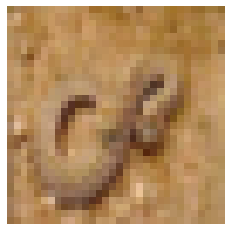

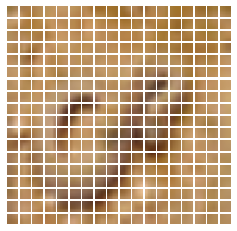

In [ ]:
#Vi-Transformer Implementation
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

#Example for CIFAR-100

num_classes=100
input_shape=(32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)


#Configure Hyper Parameters
lr=1e-2
weight_decay= 1e-3
batch_size=256
num_epochs=100
image_size=72 #resize images (32,32,3) to (72,72,3)
patch_size=4
num_patches = (image_size//patch_size)**2
projection_dim=128
num_heads=4


transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

transformer_layers=8
mlp_head_units=[2048, 1024]


#Data Augmentation as Keras Layer

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
     
    ],
    name='data_augmentation'
)

data_augmentation.layers[0].adapt(x_train)


#MLP (Multi Layer Perceptron)
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x=layers.Dense(units, activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout)(x)
    return x

#patch Creation as Layer

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size=patch_size

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates= [1,1,1,1],
            padding= 'VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1,patch_dims])
        return patches


#display patches for an image
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print("patches shape : ", patches.shape)


n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch, (patch_size, patch_size, 3))
    #print(patch_img)
    #break
    plt.imshow(patch_img.numpy().astype('int32'))
    plt.axis('off')

#pacth encoding Layer

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim =num_patches, output_dim = projection_dim
        )
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded


#build the Vi-T model

#consists of multiple transformer blocks

def create_vit_classifier():

    inputs=layers.Input(shape=input_shape)


    #augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)

    #encode patches
    temp=PatchEncoder(num_patches,projection_dim)(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    #create a [batch_size, projection_dim] tensor

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs = representation)
    return model

    


# Original Model with current best accuracy 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 72, 32)   896         data_augmentation[0][0]      

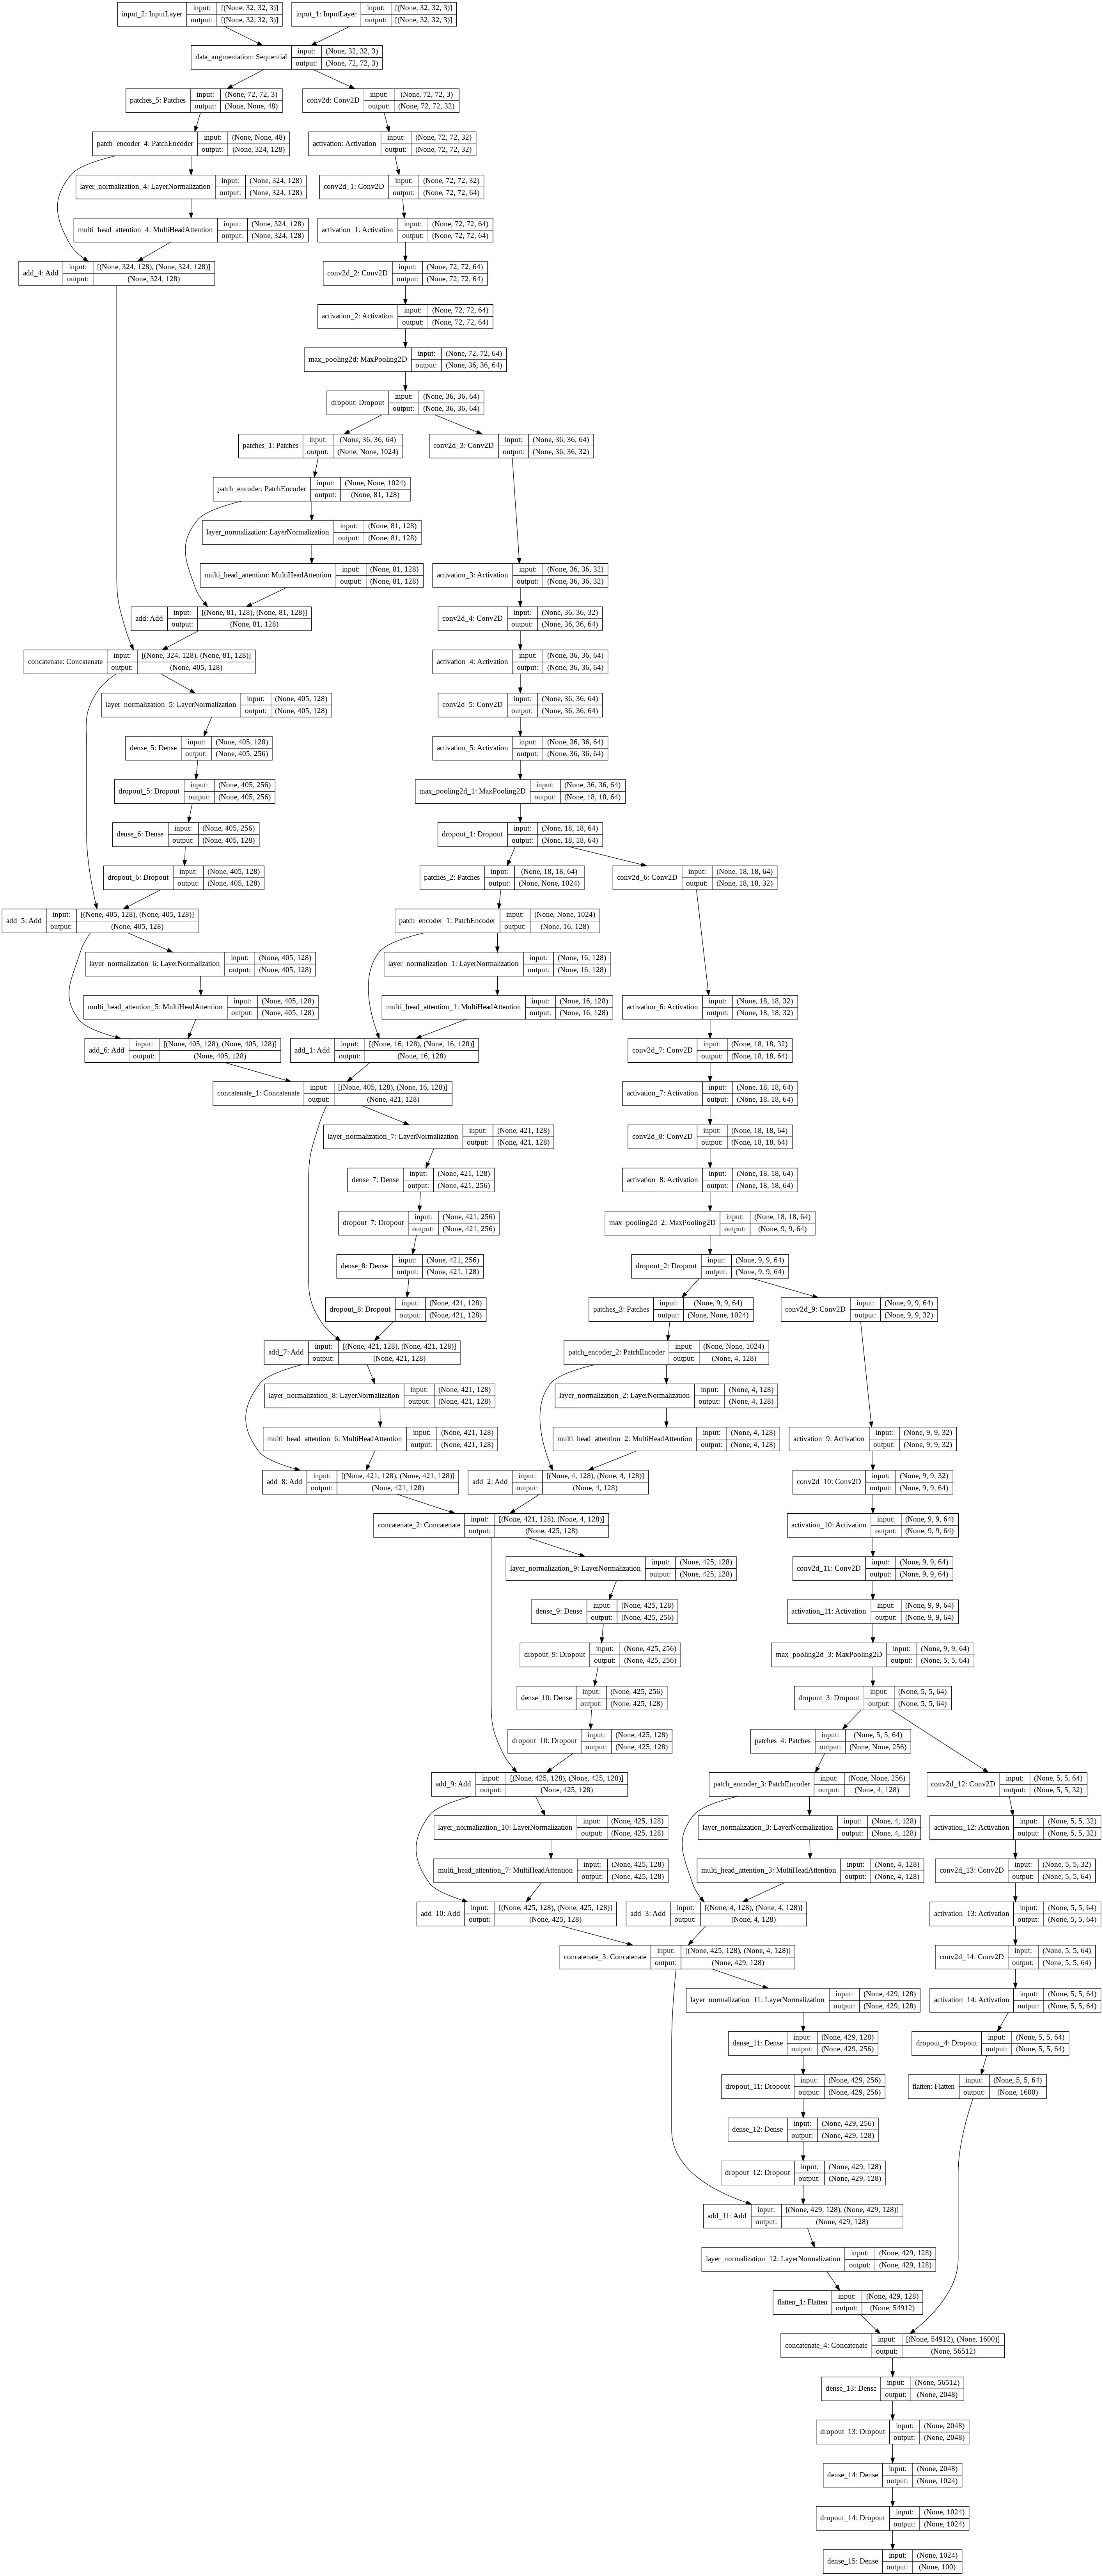

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def progressive_fusion_v2():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    norm1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm1,norm1)
    norm1 = layers.Add()([norm1, patch_encoder_1])
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    norm3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm3,norm3)
    norm3 = layers.Add()([norm3, patch_encoder_3])
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    norm4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm4,norm4)
    norm4 = layers.Add()([norm4, patch_encoder_4])
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model



progressive_model_v2 = progressive_fusion_v2()
progressive_model_v2.summary()

plot_model(progressive_model_v2, to_file="new_model.png", show_shapes=True)
progressive_model_v2.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
plot_model(progressive_model_v2, to_file="new_model.png", show_shapes=True)

# Backbone for progressive training enabled model

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations

def back_bone():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}

    """ Convolution Module """

    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)


    patches_2 = Patches(patch_size)(drop1)
    patch_encoder_2 = PatchEncoder(((72//2)//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])
    diversion = norm2



    """ Atttention Module """


    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block


    x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
    
    #skip connection 1
    x2=layers.Add()([attention_output, encoded_patches])
    #layer normalization 2
    #print("Add Shape : ", x2.shape)
    #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
    """x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])"""

    #print("concatenate shape : ", x2.shape)

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
    #skip connection 2
    #print("mlp xhape : ", x3.shape)
    encoded_patches = layers.Add()([x3, x2])
    #print("encoded_patches : ", encoded_patches.shape)
    #print("\n\n\n")
    return drop1, encoded_patches, [inputs, inputs_trans], diversion


def tail(branch1, branch2, inputs):
    print(branch1.name)
    representation = layers.LayerNormalization(epsilon=1e-6)(branch1)
    
    #print(representation.shape)
    representation = layers.GlobalMaxPool2D()(representation)
    branch2 = layers.GlobalMaxPool1D()(branch2)

    #print(representation.shape)
    combined=layers.Concatenate()([representation, branch2])
    #print(combined.shape)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    logits=Dense(100)(combined)

    model = keras.Model(inputs=inputs, outputs = logits)
    return model


def adder(branch1, branch2, in_diversion, inputs, i):

    #print("branch 1 shape : ", branch1.shape)
    #print("branch 2 shape : ", branch2.shape)

    """ Brach1 ; i.e Convolution Branch """
    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(branch1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    """ Brach 1 Diversion (Previous Branch) """
    if (i<3):
        patches_2 = Patches(patch_size)(drop2)
        patch_encoder_2 = PatchEncoder(((72//2**(i+1))//patch_size)**2, projection_dim)(patches_2)
        norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
        norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
        norm2 = layers.Add()([norm2, patch_encoder_2])
        diversion = norm2
    else:
        patches_2 = Patches(patch_size//2)(drop2)
        patch_encoder_2 = PatchEncoder(((72//2**(i+1))//patch_size//2)**2, projection_dim)(patches_2)
        norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
        norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
        norm2 = layers.Add()([norm2, patch_encoder_2])
        diversion = norm2


    """ Branch 2; i.e Attention """


    x1=layers.LayerNormalization(epsilon=1e-6)(branch2)
    attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
    
    #skip connection 1
    x2=layers.Add()([attention_output, branch2])
    #layer normalization 2
    #print("Add Shape : ", x2.shape)
    #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
    x2 = layers.Concatenate(axis = 1)([x2, in_diversion])

    #print("concatenate shape : ", x2.shape)

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
    #skip connection 2
    #print("mlp xhape : ", x3.shape)
    encoded_patches = layers.Add()([x3, x2])
    #print("encoded_patches : ", encoded_patches.shape)
    #print("\n\n\n")



    new_branch1, new_branch2 = drop2, encoded_patches

    model = tail(new_branch1, new_branch2, inputs)


    return model, diversion


def loader(model, path):
    model.load_weights(path)
    return model




def trainer(model, i):
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
    plot_model(model, to_file=str(i+1)+"_model.png", show_shapes=True)
    
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'auto', restore_best_weights= True)
    
    tf.keras.backend.clear_session()

    history = model.fit([x_train, x_train], y_train, batch_size=128, epochs=1, verbose =1, callbacks=[earlystop_callback], validation_data = ([x_test, x_test], y_test))
    return history










# Progressive addiotion of layers after training

In [ ]:
import copy

#previous_model_path = "/content/drive/My Drive/cnn-trans-fusion-progressive-train-3-oct-10pm/previous/"
all_history=[]
start = 1
num_layers = 4
model_ref = None
branches = [None, None]
diversion = 0
for i in range(num_layers):
    if (start):
        branches[0], branches[1], inputs, diversion = back_bone()
        model= tail(branches[0], branches[1], inputs)
        model_ref = model
        trainer(model_ref, i)
        print("Phase ", i+1, " Training complete!!")

        start=0


    else:
        #saved_model = keras.models.load_model(path)
        print("input branches 0 old list value: ",branches[0].name)
        print("input branches 1 old list value: ",branches[1].name)
        model, diversion = adder(branches[0], branches[1], diversion, inputs, i)
        
        branches[0] = model.get_layer(index = -8)
        branches[1] = model.get_layer(index = -7)

        print("output branche name form list : ", branches[0].name)
        print("output branches name form list : ", branches[1].name)
        #model = tail(branches[0],branches[1], inputs)
        #model_ref = keras.Model(inputs=model.inputs)
        history =  trainer(model, i)
        all_history.append(history)
        print("Phase ", i+1, " Training Complete!!")
 
        



dropout_5/Identity:0
391/391 [==============================] - 184s 462ms/step - loss: 3.8415 - acc: 0.1097 - top5-acc: 0.3148 - val_loss: 3.4135 - val_acc: 0.1747 - val_top5-acc: 0.4405
Phase  1  Training complete!!
input branches 0 old list value:  dropout_5/Identity:0
input branches 1 old list value:  add_5/add:0
dropout/Identity:0
output branche name form list :  global_max_pooling2d
output branches name form list :  global_max_pooling1d
391/391 [==============================] - 333s 836ms/step - loss: 3.6964 - acc: 0.1316 - top5-acc: 0.3609 - val_loss: 3.3778 - val_acc: 0.1896 - val_top5-acc: 0.4517
Phase  2  Training Complete!!
input branches 0 old list value:  global_max_pooling2d
input branches 1 old list value:  global_max_pooling1d


TypeError: ignored

In [ ]:
branches[0] = model.get_layer(index=-8)
branches[1] = model.get_layer(index=-7)
print(branches)

[<keras.layers.pooling.GlobalMaxPooling2D object at 0x7fc773778bd0>, <keras.layers.pooling.GlobalMaxPooling1D object at 0x7fc76c0453d0>]


# Final Stage Training after all the layers are built progressively

In [ ]:
#saved_model = keras.models.load_model(path)
print("input branches 0 : ",branches[0].name)
print("input branches 1 : ",branches[1].name)
branches[0], branches[1], diversion = adder(branches[0], branches[1], diversion, inputs, i)
print("\n\n")
"""print("output branches 0 returned layer : ",branch1.name)
print("output branches 1 returned layer : ",branch2.name)
branches[0]=branch1
branches[1]=branch2"""
print("\n\n")
print("output branches 0 from list : ", branches[0].name)
print("output branches 1 from list : ", branches[1].name)

input branches 0 :  dropout_8/Identity:0
input branches 1 :  add_8/add:0






output branches 0 from list :  dropout_11/Identity:0
output branches 1 from list :  add_11/add:0


In [ ]:
from keras.callbacks import *


checkpoint_filepath = "/content/drive/My Drive/cnn-trans-fusion-v3-3-oct-10pm/checkpoint{epoch:03d}-val_acc:{val_acc:.3f}/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    validation_data = ([x_test, x_test], y_test))

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'auto', restore_best_weights= True)
filename='/content/drive/My Drive/cnn-trans-fusion-v3-3-oct-10pm/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

tf.keras.backend.clear_session()

history = progressive_model_v3.fit([x_train, x_train], y_train, batch_size=128, epochs=150, verbose =1, callbacks=[model_checkpoint_callback, history_logger], validation_data = ([x_test, x_test], y_test))

